# A supervised model to detect unreliable text information

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not a given text information is fake.

Using this following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Defintion

In a statement,

> Dataset Description: Build a system to identify unreliable text information(Fake news).

## 2. Data

The data is available on Kaggle. https://www.kaggle.com/c/fake-news/data

## 3. Evaluation

> If we have zero(0) as the test_label value when predicting whether a text information is fake or not during the proof of concept, we 'll pursue the object
> label feature

    1: unreliable
    0: reliable

## 4. Features

> This is where you 'll get different information about each of the features in the data.



**Create data dictionary**



**Dataset Description: Build a system to identify unreliable text information:**



    * train.csv: A full training dataset with the following attributes:
      - id: unique id
      - title: the title
      - author: author
      - text: the text of the article; could be incomplete
      - label: a label that marks the article as potentially unreliable
        1: unreliable
        0: reliable
    * test.csv: A testing training dataset with all the same attributes at train.csv without the label

In [ ]:


import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import shutil
import string
import tensorflow as tf

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

from matplotlib import rcParams
import seaborn as sns


In [2]:
# Download and explore the train dataset

train_dataset = pd.read_csv("text_data/train.csv")
nRow, nCol = train_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv
train_dataset.dropna(axis=0, how='all', inplace=True)
nRow, nCol = train_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train_dataset.head()

There are 20800 rows and 5 columns in the training set
There are 20800 rows and 5 columns in the training set after removing empty rows


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Download and explore the test dataset
test_dataset = pd.read_csv("text_data/test.csv")

nRow, nCol = test_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the test set')

# Removing empty rows from csv
test_dataset.dropna(axis=0, how='all', inplace=True)
nRow, nCol = test_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the test set after removing empty rows')


There are 5200 rows and 4 columns in the test set
There are 5200 rows and 4 columns in the test set after removing empty rows


In [4]:

batch_size = 32
seed = 42

In [5]:
# Let's find out how many of each class there according to target variable
train_dataset["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 975.0+ KB


In [7]:
#Are there any missing values
train_dataset.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test_dataset.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
train_dataset[:10]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [10]:
# Cleaning train data base on empty text column

train_dataset = train_dataset[train_dataset['text'].notna()]


nRow, nCol = train_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" column')

There are 20761 rows and 5 columns in the training set after removing empty "text" column


In [11]:
#Checking for missing values
train_dataset.isna().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [12]:
# Cleaning train data base on empty text column

test_dataset = test_dataset[test_dataset['text'].notna()]


nRow, nCol = test_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" column')

There are 5193 rows and 4 columns in the training set after removing empty "text" column


In [13]:
#Checking for missing values
test_dataset.isna().sum()

id          0
title     122
author    496
text        0
dtype: int64

In [14]:
#Update nan values with ' ', for empty title and author column
train_dataset = train_dataset.fillna(' ')
test_dataset = test_dataset.fillna(' ')

In [15]:
train_dataset.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [16]:
test_dataset.isnull().sum()

id        0
title     0
author    0
text      0
dtype: int64

In [17]:

import contractions

In [18]:
#while doing the contraction mapping, the team found out that we had a edge-case, where the word below, because how it had some special characters, failed! so, this step is taking out all the rows that contains that word

train_dataset = train_dataset[~train_dataset['text'].str.contains("İletişim")]

nRow, nCol = train_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing edge-case word "İletişim"')

train_dataset.head()

There are 20755 rows and 5 columns in the training set after removing edge-case word "İletişim"


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:
test_dataset = test_dataset[~test_dataset['text'].str.contains("İletişim")]

nRow, nCol = test_dataset.shape
print(f'There are {nRow} rows and {nCol} columns in the test set after removing edge-case word "İletişim"')

test_dataset.head()

There are 5190 rows and 4 columns in the test set after removing edge-case word "İletişim"


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [20]:
train_dataset['total']=train_dataset['title']+' '+train_dataset['author']+train_dataset['text']
test_dataset['total']=test_dataset['title']+' '+test_dataset['author']+test_dataset['text']

print("Done - Combined column title, author, and text in one column for training data to have more content")

Done - Combined column title, author, and text in one column for training data to have more content


In [21]:
train_dataset['total'] = train_dataset['total'].apply(lambda x: [contractions.fix(word) for word in x.split()])
train_dataset.drop(["title","author","text"], axis=1, inplace = True)


# rws['no_contract'] = rws['rating_description'].apply(lambda x: [contractions.fix(word) for word in x.split()])
# rws.head()

test_dataset['total'] = test_dataset['total'].apply(lambda x: [contractions.fix(word) for word in x.split()])
test_dataset.drop(["title","author","text"], axis=1, inplace = True)


In [22]:
# for i in test_dataset['total']:
#     word = i.split(' ')
#     print(word[:9])
#   for j in word:
# #     print(j)
#     result = contractions.fix(j)
#     print(result)

In [23]:
train_dataset.head()

,id,label,total
0,0,1,"[House, Dem, Aide:, We, did not, Even, See, Co..."
1,1,0,"[FLYNN:, Hillary, Clinton,, Big, Woman, on, Ca..."
2,2,1,"[Why, the, Truth, Might, Get, You, Fired, Cons..."
3,3,1,"[15, Civilians, Killed, In, Single, US, Airstr..."
4,4,1,"[Iranian, woman, jailed, for, fictional, unpub..."


In [24]:
test_dataset.head()

,id,total
0,20800,"[Specter, of, Trump, Loosens, Tongues,, if, No..."
1,20801,"[Russian, warships, ready, to, strike, terrori..."
2,20802,"[#NoDAPL:, Native, American, Leaders, Vow, to,..."
3,20803,"[Tim, Tebow, Will, Attempt, Another, Comeback,..."
4,20804,"[Keiser, Report:, Meme, Wars, (E995), Truth, B..."


In [25]:
#joining back the list of items into one string
train_dataset['total'] = [' '.join(map(str, l)) for l in train_dataset['total']]
test_dataset['total'] = [' '.join(map(str, l)) for l in test_dataset['total']]
train_dataset.head()

,id,label,total
0,0,1,House Dem Aide: We did not Even See Comey’s Le...
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,1,Why the Truth Might Get You Fired Consortiumne...
3,3,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,1,Iranian woman jailed for fictional unpublished...


In [26]:
test_dataset.head()

,id,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995) Truth Broadcas...


In [27]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train_dataset['total'] = train_dataset['total'].str.lower()
train_dataset['total'] = train_dataset['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train_dataset.head()

,id,label,total
0,0,1,house dem aide we did not even see comeys lett...
1,1,0,flynn hillary clinton big woman on campus bre...
2,2,1,why the truth might get you fired consortiumne...
3,3,1,15 civilians killed in single us airstrike hav...
4,4,1,iranian woman jailed for fictional unpublished...


In [28]:
test_dataset['total'] = test_dataset['total'].str.lower()
test_dataset['total'] = test_dataset['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train_dataset.head()

,id,label,total
0,0,1,house dem aide we did not even see comeys lett...
1,1,0,flynn hillary clinton big woman on campus bre...
2,2,1,why the truth might get you fired consortiumne...
3,3,1,15 civilians killed in single us airstrike hav...
4,4,1,iranian woman jailed for fictional unpublished...


In [29]:
test_dataset.head()

,id,total
0,20800,specter of trump loosens tongues if not purse ...
1,20801,russian warships ready to strike terrorists ne...
2,20802,nodapl native american leaders vow to stay all...
3,20803,tim tebow will attempt another comeback this t...
4,20804,keiser report meme wars e995 truth broadcast n...


In [30]:

train_dataset['total_tokenize'] = train_dataset['total'].apply(word_tokenize)
test_dataset['total_tokenize'] = test_dataset['total'].apply(word_tokenize)

train_dataset.head()

,id,label,total,total_tokenize
0,0,1,house dem aide we did not even see comeys lett...,"[house, dem, aide, we, did, not, even, see, co..."
1,1,0,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, on, camp..."
2,2,1,why the truth might get you fired consortiumne...,"[why, the, truth, might, get, you, fired, cons..."
3,3,1,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, in, single, us, airstr..."
4,4,1,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, for, fictional, unpub..."


In [31]:
test_dataset.head()

,id,total,total_tokenize
0,20800,specter of trump loosens tongues if not purse ...,"[specter, of, trump, loosens, tongues, if, not..."
1,20801,russian warships ready to strike terrorists ne...,"[russian, warships, ready, to, strike, terrori..."
2,20802,nodapl native american leaders vow to stay all...,"[nodapl, native, american, leaders, vow, to, s..."
3,20803,tim tebow will attempt another comeback this t...,"[tim, tebow, will, attempt, another, comeback,..."
4,20804,keiser report meme wars e995 truth broadcast n...,"[keiser, report, meme, wars, e995, truth, broa..."


In [32]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

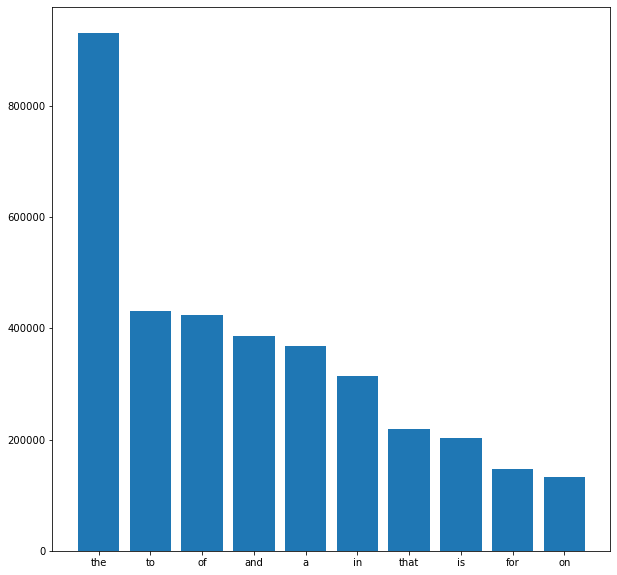

In [34]:
plot_top_stopwords_barchart(train_dataset['total'])

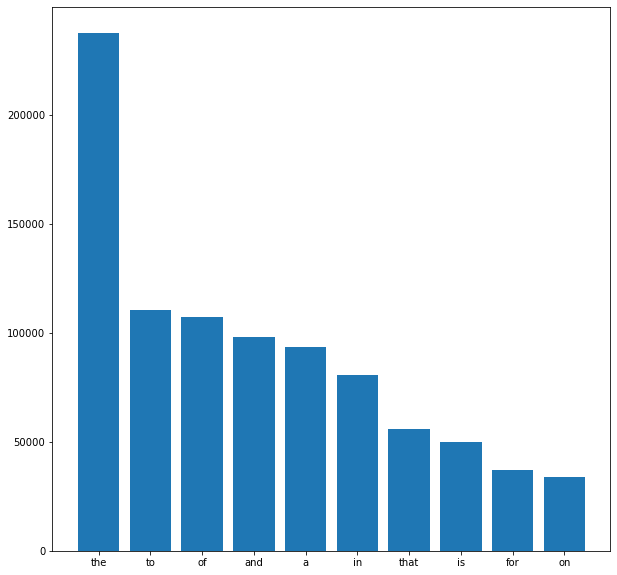

In [35]:
plot_top_stopwords_barchart(test_dataset['total'])

In [36]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

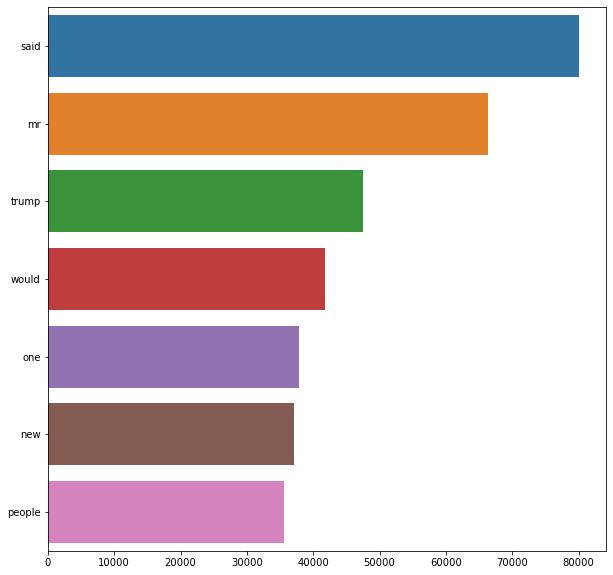

In [37]:
plot_top_non_stopwords_barchart(train_dataset['total'])

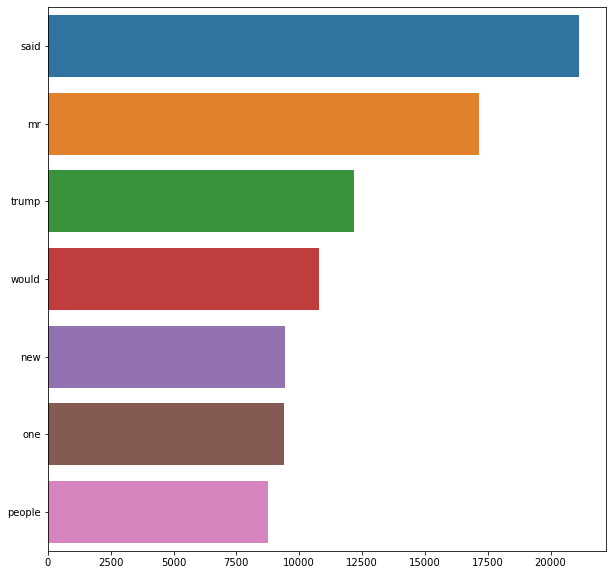

In [38]:
plot_top_non_stopwords_barchart(test_dataset['total'])

In [39]:
# Now we remove stopwords 

train_dataset['total_tokenize'] = train_dataset['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train_dataset['total_tokenize_join'] = [' '.join(map(str, l)) for l in train_dataset['total_tokenize']]

train_dataset.head()

,id,label,total,total_tokenize,total_tokenize_join
0,0,1,house dem aide we did not even see comeys lett...,"[house, dem, aide, even, see, comeys, letter, ...",house dem aide even see comeys letter jason ch...
1,1,0,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitba...
2,2,1,why the truth might get you fired consortiumne...,"[truth, might, get, fired, consortiumnewscomwh...",truth might get fired consortiumnewscomwhy tru...
3,3,1,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, single, us, airstrike,...",15 civilians killed single us airstrike identi...
4,4,1,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


In [40]:
test_dataset['total_tokenize'] = test_dataset['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
test_dataset['total_tokenize_join'] = [' '.join(map(str, l)) for l in test_dataset['total_tokenize']]

test_dataset.head()

,id,total,total_tokenize,total_tokenize_join
0,20800,specter of trump loosens tongues if not purse ...,"[specter, trump, loosens, tongues, purse, stri...",specter trump loosens tongues purse strings si...
1,20801,russian warships ready to strike terrorists ne...,"[russian, warships, ready, strike, terrorists,...",russian warships ready strike terrorists near ...
2,20802,nodapl native american leaders vow to stay all...,"[nodapl, native, american, leaders, vow, stay,...",nodapl native american leaders vow stay winter...
3,20803,tim tebow will attempt another comeback this t...,"[tim, tebow, attempt, another, comeback, time,...",tim tebow attempt another comeback time baseba...
4,20804,keiser report meme wars e995 truth broadcast n...,"[keiser, report, meme, wars, e995, truth, broa...",keiser report meme wars e995 truth broadcast n...


In [41]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train_dataset['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [42]:
# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in test_dataset['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

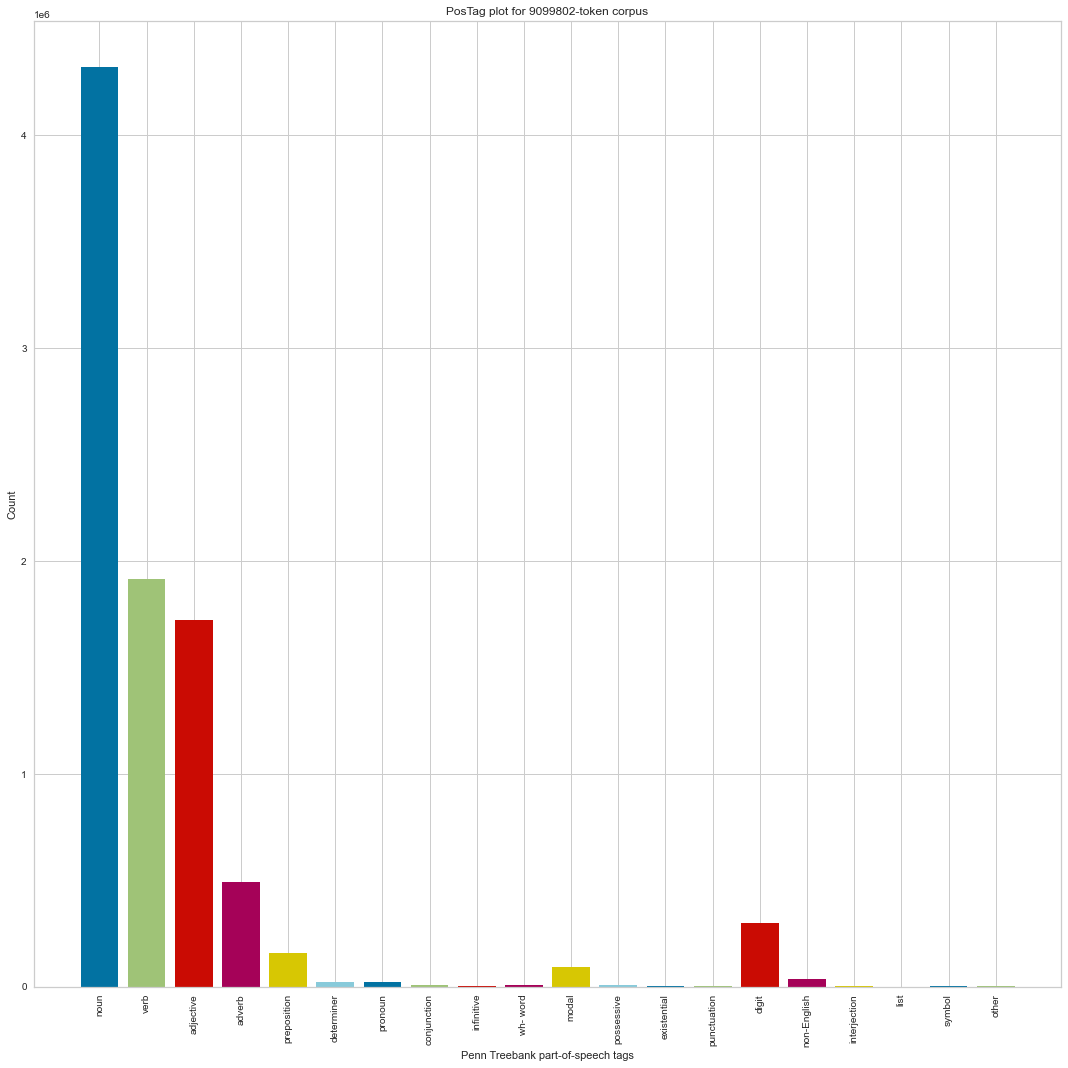

<AxesSubplot:title={'center':'PosTag plot for 9099802-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [44]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer

plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

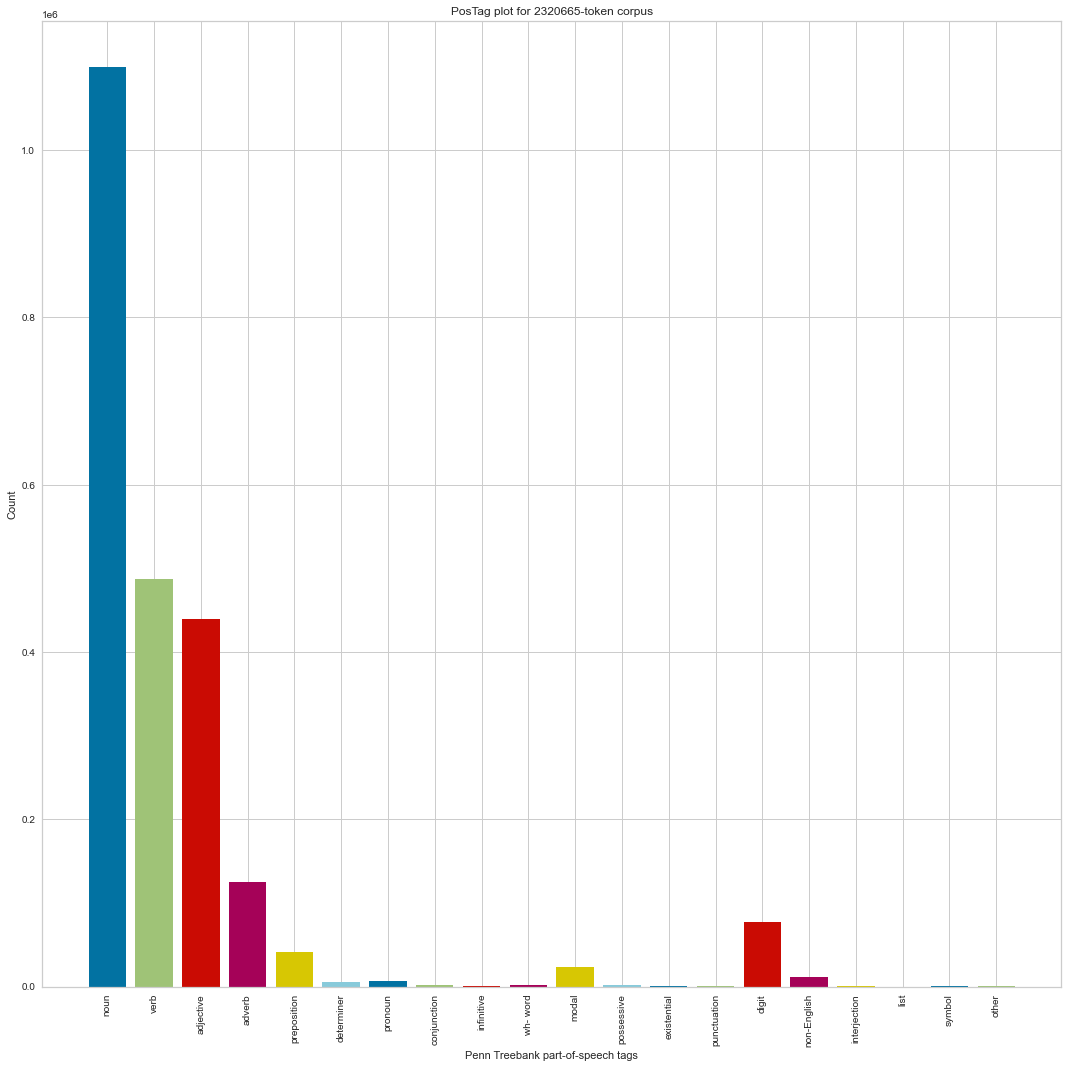

<AxesSubplot:title={'center':'PosTag plot for 2320665-token corpus'}, xlabel='Penn Treebank part-of-speech tags', ylabel='Count'>

In [45]:
# Create the visualizer for test test

from yellowbrick.text import PosTagVisualizer

plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_test)
viz.show()

In [46]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train_dataset["label"].value_counts()

0    10387
1    10368
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

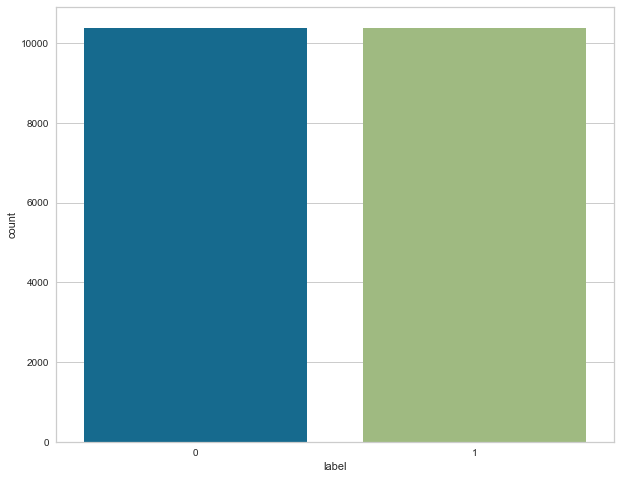

In [47]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train_dataset["label"])

In [48]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train_dataset['label'].values

# Drop the 'label' column from train dataset
train_dataset.drop("label", axis=1, inplace = True)
train_dataset.head()

,id,total,total_tokenize,total_tokenize_join
0,0,house dem aide we did not even see comeys lett...,"[house, dem, aide, even, see, comeys, letter, ...",house dem aide even see comeys letter jason ch...
1,1,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitba...
2,2,why the truth might get you fired consortiumne...,"[truth, might, get, fired, consortiumnewscomwh...",truth might get fired consortiumnewscomwhy tru...
3,3,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, single, us, airstrike,...",15 civilians killed single us airstrike identi...
4,4,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


In [49]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [50]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train_dataset['total'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)

In [51]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)

In [52]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.85


In [53]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.97
Accuracy of Adaboost classifier on test set: 0.96


In [54]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))


Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.82


In [55]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.86
Accuracy of NB classifier on test set: 0.75


In [56]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.98


* Measuring Model Performance

* While there are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc), we are going to keep this simple and use accuracy as our metric.

* Accuracy is defined as:

* fraction of correct predictions: correct predictions / total number of data points

In [57]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.9768741568703025


In [58]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 97.69%


Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, I am just showing two python packages (Seaborn and Matplotlib) for making confusion matrices more understandable and visually appealing.

The confusion matrix below is not visually super informative or visually appealing.

In [59]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[2531   76]
 [  44 2538]]


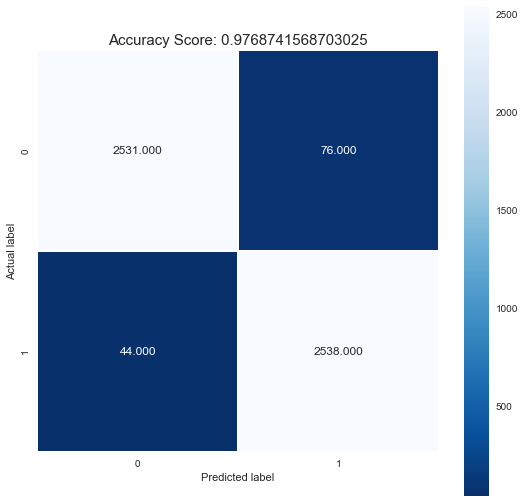

In [60]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## From the confusion matrix we can make the following conclusions:
1. Our model successfully predicted 2530 positives
2. Our model successfully predicted 2527 negatives.
3. Our model predicted 77 false positives
4. Our model predicted 45 false negatives

In [61]:
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(test_dataset['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['id']=test_dataset['id']
pred.groupby('test_label').count()

,id
test_label,
0,2585
1,2595


*************************************
Test the model with a value
*************************************
      id                                              title            author  \
0  20800  Specter of Trump Loosens Tongues, if Not Purse...  David Streitfeld   

                                                text  
0  PALO ALTO, Calif.  —   After years of scorning...  
id        0
title     0
author    0
text      0
dtype: int64
*************************************************
Done - Combined column title, author, and text in one column for training data to have more content
*************************************************
*************************************************
      id                                              total
0  20800  Specter of Trump Loosens Tongues, if Not Purse...
*************************************************
      id                                              total
0  20800  specter of trump loosens tongues if not purse ...
**********************

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*************************************************


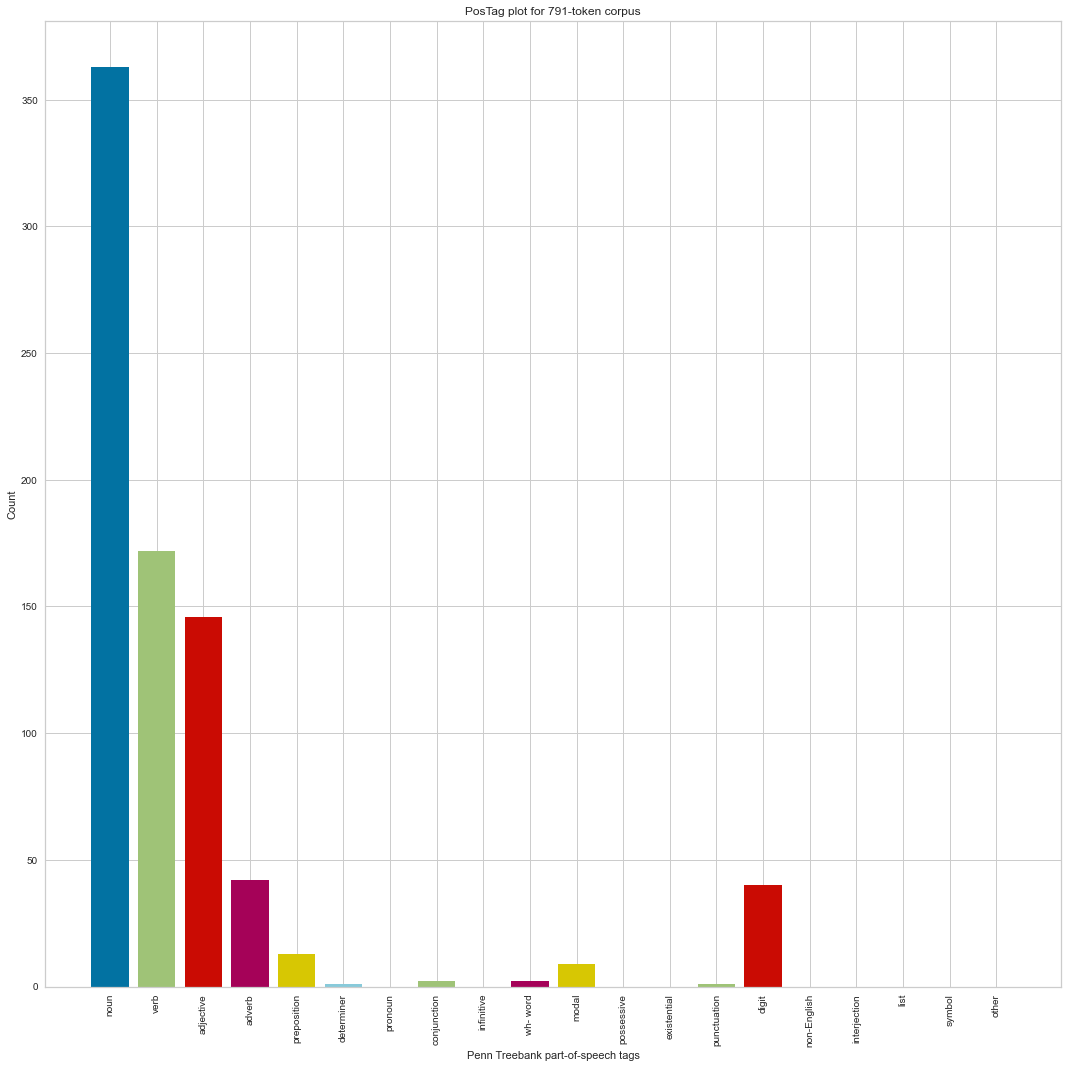

*************************************************
            id
test_label    
0            1


In [122]:
### Given a test value to test the model by calling the logreg.predict on the test value
### If result is 1: it is unreliable, elif 0: it is reliable

print('*************************************')
print('Test the model with a value')
print('*************************************')


df = pd.read_csv('Result/check_result.csv')
print(df)

#Are there any missing values
# train_dataset.isna().sum()

num_of_null = df.isna().sum()
print(num_of_null)

print('*************************************************')
df['total']=df['title']+' '+df['author']+df['text']

print("Done - Combined column title, author, and text in one column for training data to have more content")

print('*************************************************')
df['total'] = df['total'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df.drop(["title","author","text"], axis=1, inplace = True)

print('*************************************************')
df['total'] = [' '.join(map(str, l)) for l in df['total']]
print(df.head())

print('*************************************************')
df['total'] = df['total'].str.lower()
df['total'] = df['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

print(df.head())

print('*************************************************')
df['total_tokenize'] = df['total'].apply(word_tokenize)

print(df.head())


print('*************************************************')

# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


print('*************************************************')
df['total_tokenize'] = df['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
df['total_tokenize_join'] = [' '.join(map(str, l)) for l in df['total_tokenize']]

print(df.head())

print('*************************************************')
# Let's evaluate the POS tags for our test set data
tagged_stanzas_df = []
tagged_df = []

for word in df['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_df.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_df.append(tagged_stanzas_test)

print('*************************************************')
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_df)
viz.show()


print('*************************************************')
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(df['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['id']=df['id']
print(pred.groupby('test_label').count())




### label: a label that marks the article as potentially unreliable
* 1: unreliable
* 0: reliable